In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# config to let jupyter run longer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import csv file

In [60]:
df = pd.read_csv('mental-heath-in-tech-2016_20161114.csv', encoding='utf-8')

print head and info for some overview of the data

In [61]:
print(df.head())

   Are you self-employed?  \
0                       0   
1                       0   
2                       0   
3                       1   
4                       0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \


In [62]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0   Are you self-employed?                                                                                                                                                            1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

### descriptive statistics
because there are so man columns i write the statistics into a .txt file

In [63]:
# Function to get descriptive statistics for categorical variables
def categorical_stats(series):
    counts = series.value_counts()
    percentages = counts / len(series) * 100
    return pd.concat([counts, percentages], axis=1, keys=['Count', 'Percentage'])

# Function to get descriptive statistics for numerical variables
def numerical_stats(series):
    return series.describe()

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Open a file to write the results
with open('dataset_statistics.txt', 'w') as f:
    f.write("Categorical Variables:\n")
    for col in categorical_cols:
        f.write(f"\n{col}:\n")
        stats = categorical_stats(df[col])
        # Reset index to avoid double column names
        stats.index.name = None
        f.write(stats.to_string())
        f.write("\n")

    f.write("\n\nNumerical Variables:\n")
    for col in numerical_cols:
        f.write(f"\n{col}:\n")
        f.write(str(numerical_stats(df[col])))
        f.write("\n")

print("Statistics have been saved to 'dataset_statistics.txt'")

23

61

237

1

84

254

1

98

131

1

137

127

1

110

127

1

145

127

1

110

321

1

109

99

1

108

99

1

86

99

1

97

99

1

86

127

1

134

68

1

83

159

1

127

365

1

127

127

1

121

365

1

121

199

1

78

199

1

135

134

1

64

184

1

92

254

1

132

184

1

111

147

1

143

159

1

114

179

1

113

143

1

94

223

1

95

279

1

96

184

1

121

143

1

102

99

1

18

2718257

1

86

99

1

20

1224772

1

99

275

1

129

287

1

92

510

1

141

189

1

179

99

1

50

127

1

53

99

1

50

99

1

58

45278

1

55

34699

1

84

68

1

52

35684

1

115

239

1

119

239

1

23

12566

1

31

2375

1

45

1919

1

31

2375

1

45

1959

1

60

41869

1

24

115

1

23

25

212

1

58

245

1

63

242

1

120

299

1

34

221

1

94

281

1

20

207

1

Statistics have been saved to 'dataset_statistics.txt'


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Do you currently have a mental health disorder?'>

Text(0.5, 1.0, 'Distribution of Mental Health Conditions')

Text(0.5, 0, 'Response')

Text(0, 0.5, 'Count')

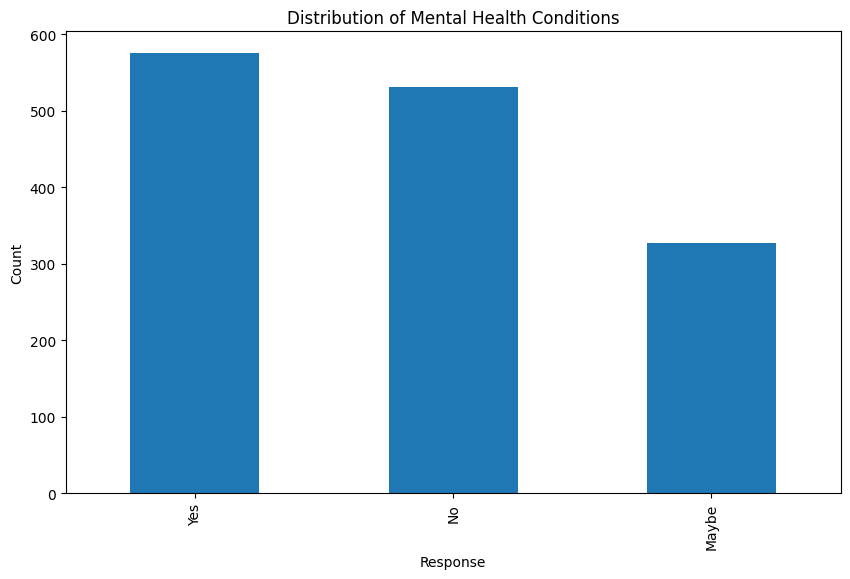

In [64]:
# 1. Bar plot: Mental health condition distribution
plt.figure(figsize=(10, 6))
df['Do you currently have a mental health disorder?'].value_counts().plot(kind='bar')
plt.title('Distribution of Mental Health Conditions')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

<Figure size 800x800 with 0 Axes>

<Axes: ylabel='count'>

Text(0.5, 1.0, 'Gender Distribution')

Text(0, 0.5, '')

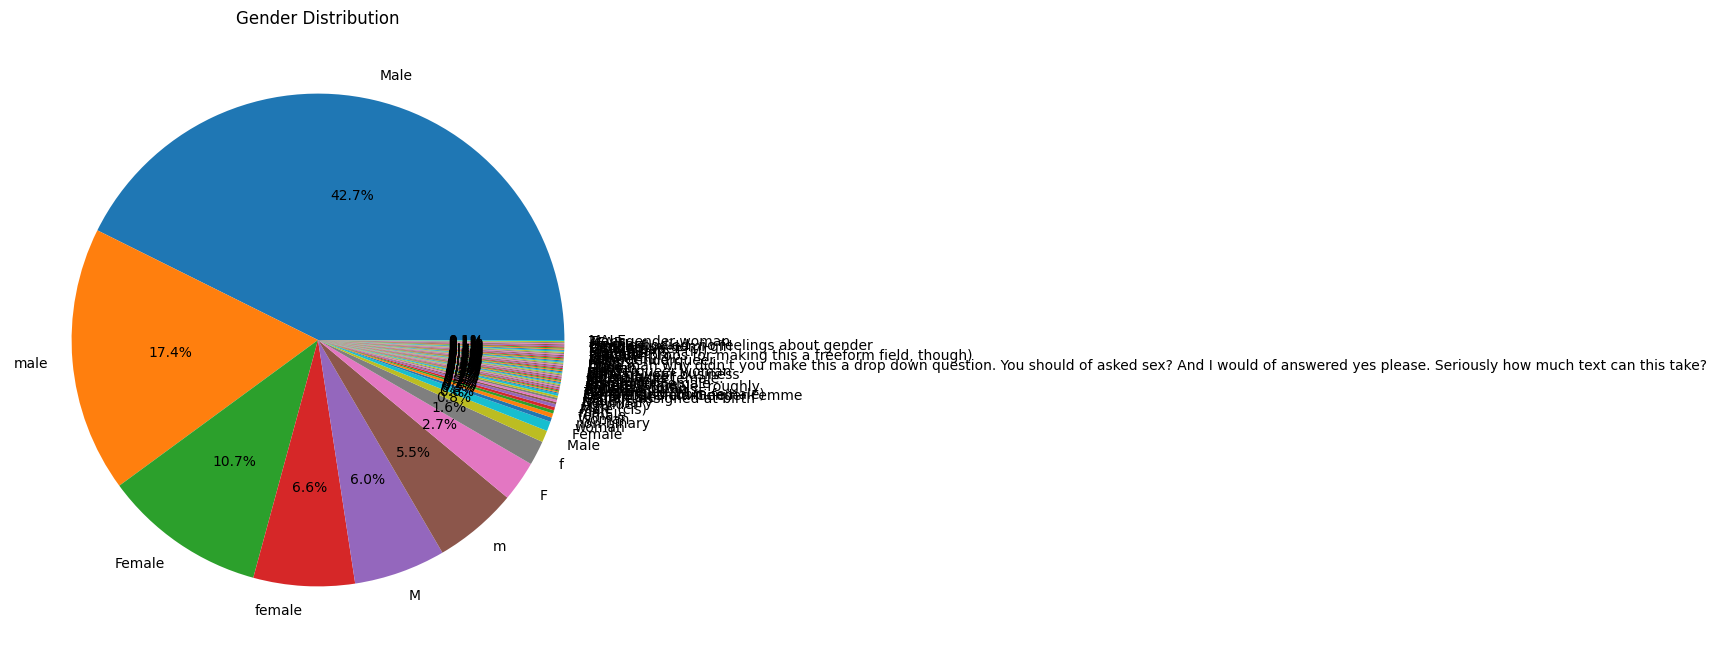

In [65]:
# 2. Pie chart: Gender distribution
plt.figure(figsize=(8, 8))
df['What is your gender?'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Age Distribution')

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Count')

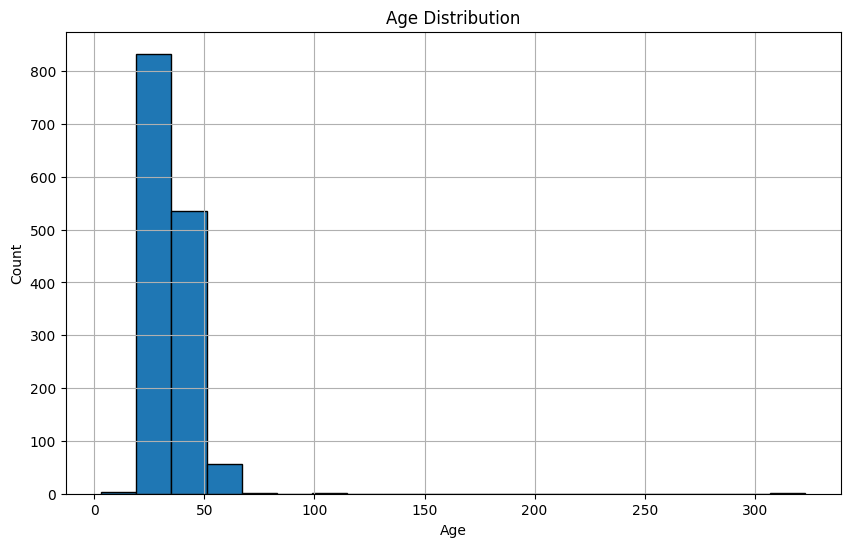

In [66]:
# 3. Histogram: Age distribution
plt.figure(figsize=(10, 6))
df['What is your age?'].hist(bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Figure size 1200x1000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Variables')

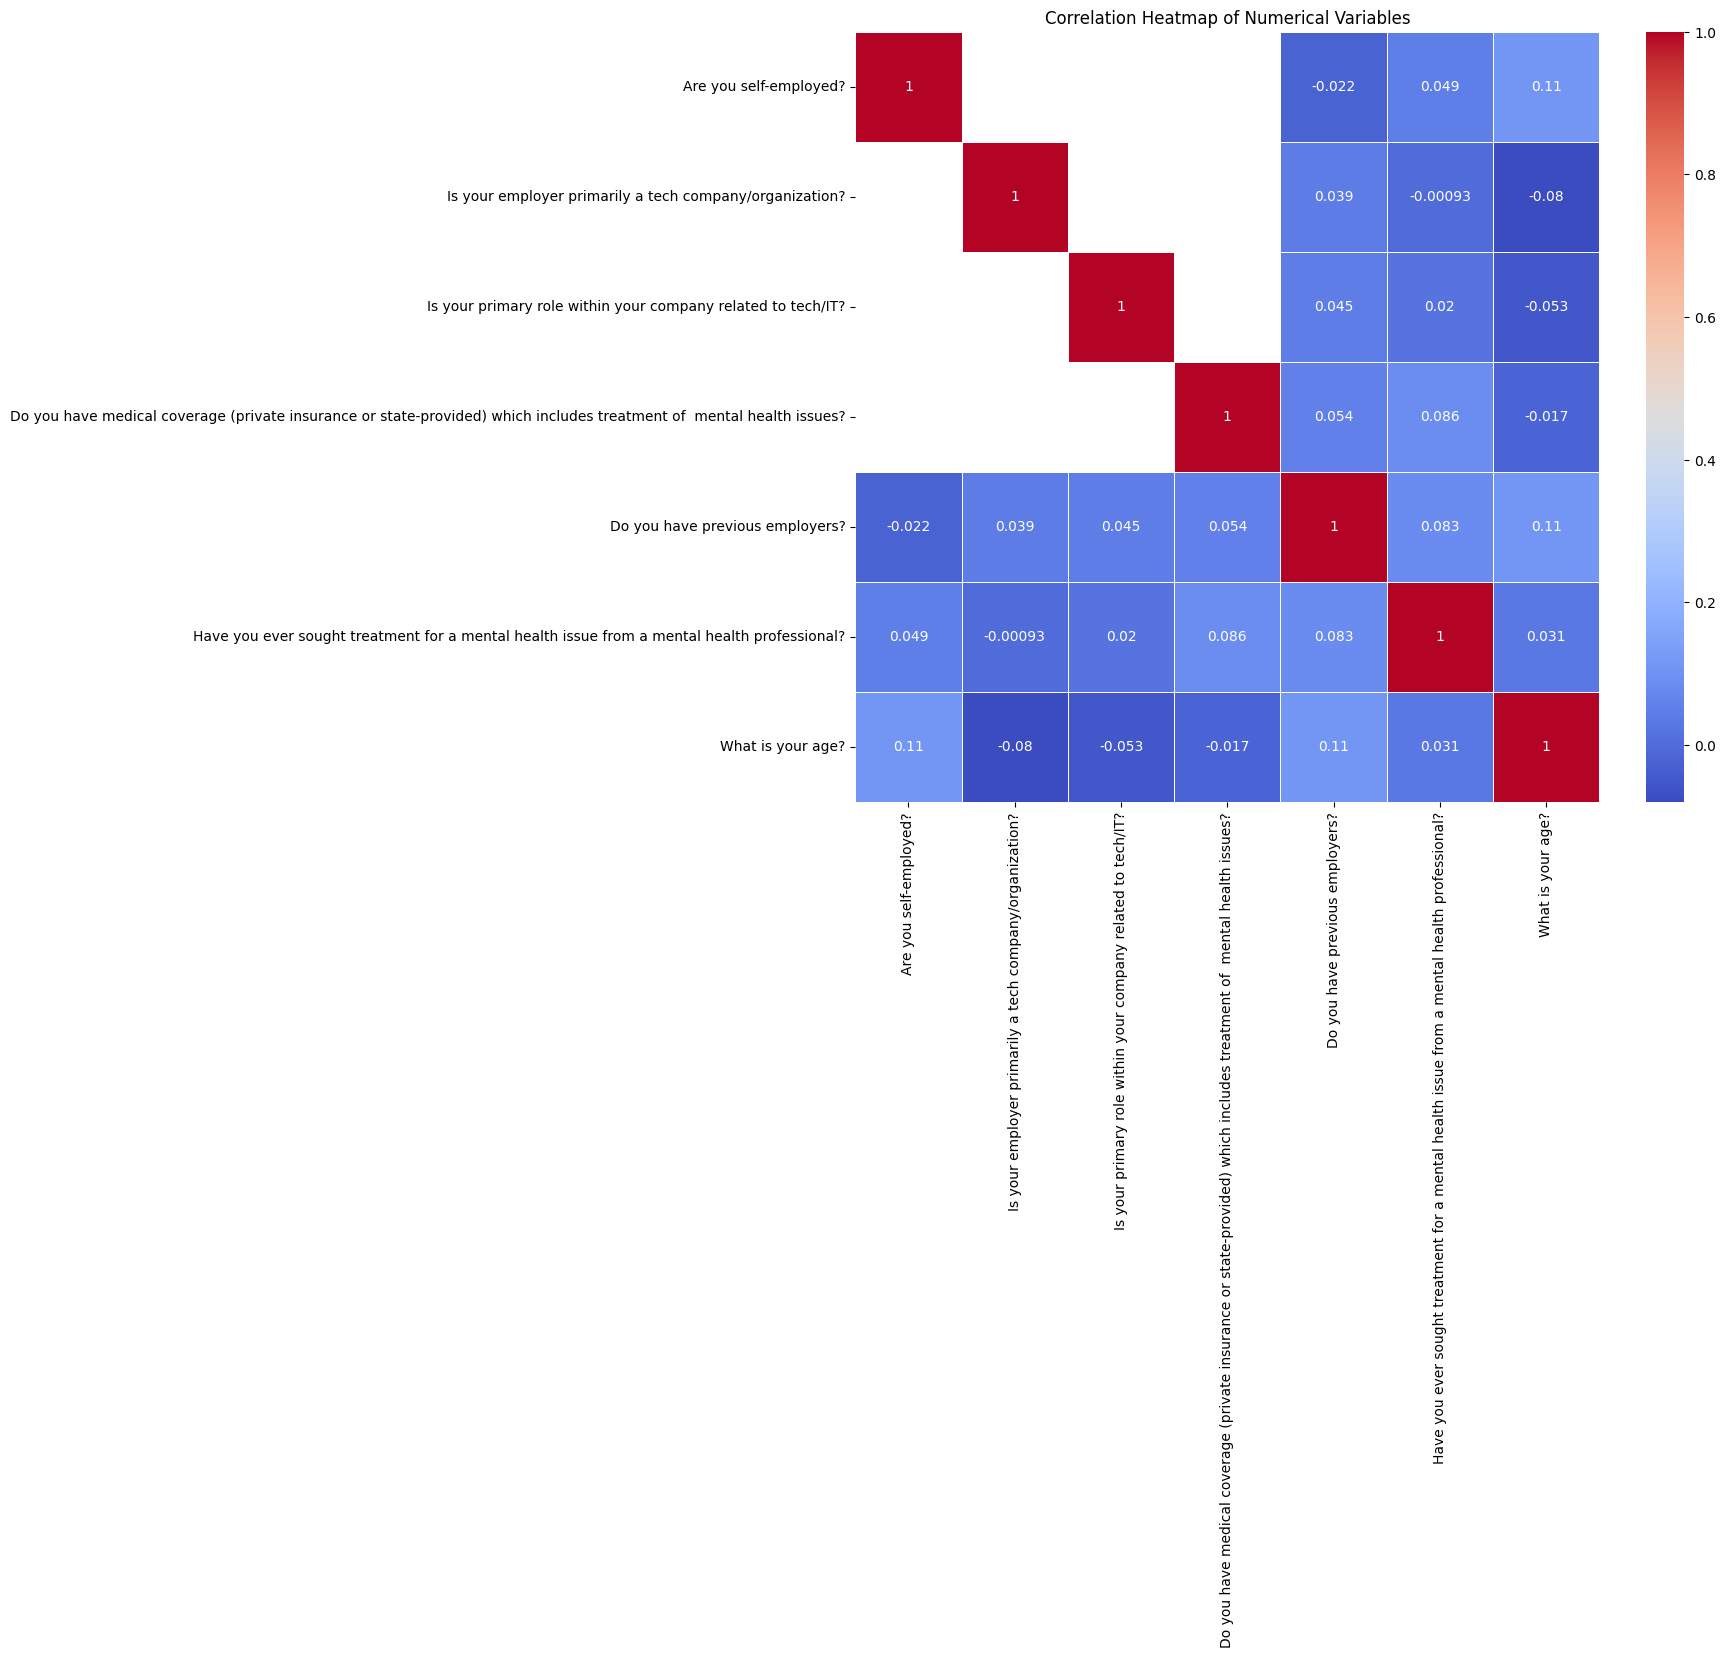

In [67]:
# 5. Heatmap: Correlation between numerical variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Do you currently have a mental health disorder?', ylabel='What is your age?'>

Text(0.5, 1.0, 'Age Distribution by Mental Health Condition')

Text(0.5, 0, 'Mental Health Condition')

Text(0, 0.5, 'Age')

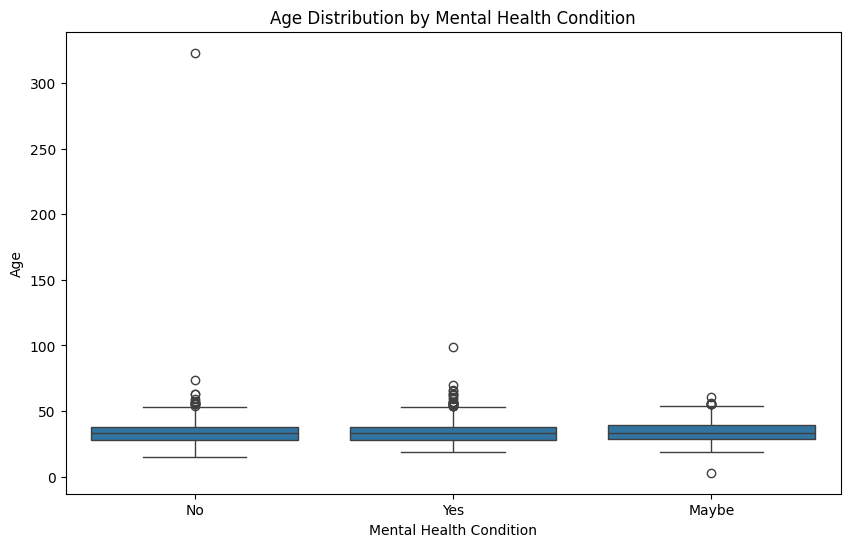

In [68]:
# 6. Box plot: Age distribution by mental health condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='Do you currently have a mental health disorder?', y='What is your age?', data=df)
plt.title('Age Distribution by Mental Health Condition')
plt.xlabel('Mental Health Condition')
plt.ylabel('Age')
plt.show()